# Exploratory Data Analysis: Birth Control Mental Health Posts

## Learning Objectives
- Understand the structure of collected Reddit data
- Perform basic statistical analysis
- Visualize text data distributions
- Identify patterns and prepare for NLP/LLM tasks

## What is EDA?
Exploratory Data Analysis (EDA) is the critical first step in any ML/AI project:
- **Understand your data**: What do you actually have?
- **Identify quality issues**: Missing data, duplicates, errors
- **Find patterns**: What insights emerge before modeling?
- **Guide decisions**: What preprocessing/modeling approach makes sense?

Rule of thumb: Spend 80% of time on data quality, 20% on modeling.

In [1]:
# Import required libraries
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
from collections import Counter
import re

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Display settings for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 1. Load and Inspect Data

First, let's load our collected Reddit posts and examine the structure.

In [2]:
# Find the most recent data file
data_dir = Path('../data/raw')
data_files = list(data_dir.glob('reddit_mental_health_posts_*.json'))

if not data_files:
    print("⚠️  No data files found!")
    print("   Please run: python src/data_collection/reddit_collector.py")
else:
    # Use the most recent file
    latest_file = max(data_files, key=lambda p: p.stat().st_mtime)
    print(f"📂 Loading: {latest_file.name}")
    
    # Load JSON data
    with open(latest_file, 'r', encoding='utf-8') as f:
        posts_raw = json.load(f)
    
    # Convert to pandas DataFrame for easier analysis
    # LEARNING: DataFrames are the standard for tabular data in Python
    df = pd.DataFrame(posts_raw)
    
    print(f"✓ Loaded {len(df)} posts")
    print(f"\nDataFrame shape: {df.shape[0]} rows × {df.shape[1]} columns")

📂 Loading: reddit_mental_health_posts_20251027_153123.json
✓ Loaded 300 posts

DataFrame shape: 300 rows × 15 columns


In [3]:
# Examine first few rows
# LEARNING: Always inspect raw data before analysis
df.head()

,id,created_utc,created_date,title,selftext,text_length,subreddit,score,upvote_ratio,num_comments,is_self,link_flair_text,permalink,collected_at,top_comments
0,1nwlqnr,1.759454e+09,2025-10-03T09:12:10,Birth Control anxiety due to current US beliefs,"As the title says, I’m feeling more and more nervous about the future of reproductive healthcare...",958,birthcontrol,64,0.92,61,True,Which Method?,https://reddit.com/r/birthcontrol/comments/1nwlqnr/birth_control_anxiety_due_to_current_us_beliefs/,2025-10-27T15:14:49.981106,"[{'id': 'nhgw5vg', 'text': 'Yes. Absolutely. Obviously you will need to speak to your healthcar..."
1,1lxmpzg,1.752279e+09,2025-07-12T08:16:47,Read if you suffer from pregnancy anxiety:),Hello lovely ladies of reddit! I have suffered from terrible pregnancy anxiety for much of my li...,2967,birthcontrol,254,1.00,42,True,Educational,https://reddit.com/r/birthcontrol/comments/1lxmpzg/read_if_you_suffer_from_pregnancy_anxiety/,2025-10-27T15:14:52.575380,"[{'id': 'n2ndzpz', 'text': 'This is really helpful thank you 🫶🏻 I’ve struggled with pregnancy an..."
2,1k9c788,1.745782e+09,2025-04-28T03:26:42,I have so many emotions. Pregnant on mini pill with my 3rd.,My period is 1 day late. I take Norethindrone religiously because I have two children ages 4 and...,600,birthcontrol,77,0.99,63,True,Experience,https://reddit.com/r/birthcontrol/comments/1k9c788/i_have_so_many_emotions_pregnant_on_mini_pill/,2025-10-27T15:14:55.358222,"[{'id': 'mpd443l', 'text': 'It’ll be ok. You caught this early and that’s the best possible outc..."
3,1n7txbo,1.756941e+09,2025-09-04T07:05:56,Gf rarely in the mood with hormonal IUD,"Hi guys,\n\nMe (20M) and my gf (22F) have been together for around 4 months now. She got a hormo...",1235,birthcontrol,12,0.93,26,True,Side effects!?,https://reddit.com/r/birthcontrol/comments/1n7txbo/gf_rarely_in_the_mood_with_hormonal_iud/,2025-10-27T15:14:58.362274,"[{'id': 'ncbgkkr', 'text': 'Remember she got this for the both of you to reduce risk as much as ..."
4,1mlpzyq,1.754748e+09,2025-08-09T21:53:31,I'm just so torn and emotionally done with the pill.,"I just need to get this out there, this will be a vent. It's my first month on yaz, combo pills,...",1129,birthcontrol,9,0.85,29,True,Rant!,https://reddit.com/r/birthcontrol/comments/1mlpzyq/im_just_so_torn_and_emotionally_done_with_the...,2025-10-27T15:15:00.993095,"[{'id': 'n7s09wu', 'text': 'I suggest you go back to your doctor and discuss it with them.', 'sc..."


In [4]:
# Data types and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               300 non-null    object 
 1   created_utc      300 non-null    float64
 2   created_date     300 non-null    object 
 3   title            300 non-null    object 
 4   selftext         300 non-null    object 
 5   text_length      300 non-null    int64  
 6   subreddit        300 non-null    object 
 7   score            300 non-null    int64  
 8   upvote_ratio     300 non-null    float64
 9   num_comments     300 non-null    int64  
 10  is_self          300 non-null    bool   
 11  link_flair_text  203 non-null    object 
 12  permalink        300 non-null    object 
 13  collected_at     300 non-null    object 
 14  top_comments     300 non-null    object 
dtypes: bool(1), float64(2), int64(3), object(9)
memory usage: 33.2+ KB


In [5]:
# Statistical summary
df.describe()

,created_utc,text_length,score,upvote_ratio,num_comments
count,3.000000e+02,300.000000,300.000000,300.000000,300.000000
mean,1.752316e+09,1079.410000,1443.390000,0.945233,168.773333
std,8.797761e+06,1136.434215,4097.856507,0.091342,562.918567
min,1.730221e+09,0.000000,0.000000,0.250000,0.000000
25%,1.746971e+09,362.500000,3.000000,0.930000,8.000000
50%,1.755834e+09,711.000000,72.500000,0.980000,30.500000
75%,1.759165e+09,1395.500000,823.000000,1.000000,111.750000
max,1.761509e+09,6579.000000,44688.000000,1.000000,8494.000000


## 2. Data Quality Checks

Before any analysis, we need to check data quality:
- Missing values
- Duplicates
- Data consistency

In [6]:
# Check for missing values
print("Missing Values:")
print("=" * 40)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Percentage': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

# INSIGHT: Empty selftext is common for link posts
# We'll filter for text posts later

Missing Values:
                 Missing Count  Percentage
link_flair_text             97   32.333333


In [7]:
# Check for duplicates
duplicates = df.duplicated(subset=['id']).sum()
print(f"\nDuplicate posts: {duplicates}")

if duplicates > 0:
    print("Removing duplicates...")
    df = df.drop_duplicates(subset=['id'], keep='first')
    print(f"✓ After deduplication: {len(df)} posts")


Duplicate posts: 0


In [8]:
# Filter for text posts only (where we have content to analyze)
text_posts = df[df['is_self'] == True].copy()
text_posts = text_posts[text_posts['text_length'] > 0]

print(f"Text posts with content: {len(text_posts)} / {len(df)}")
print(f"Percentage: {len(text_posts)/len(df)*100:.1f}%")

Text posts with content: 264 / 300
Percentage: 88.0%


## 3. Distribution Analysis

Understanding the distribution of our data helps us:
- Identify outliers
- Understand typical post characteristics
- Plan preprocessing strategies

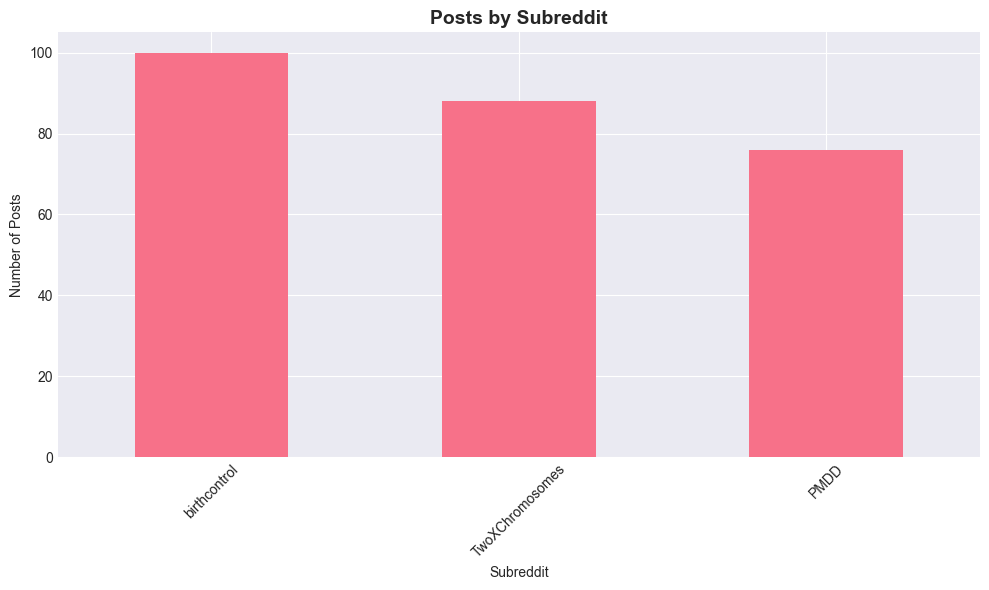


Posts per subreddit:
subreddit
birthcontrol       100
TwoXChromosomes     88
PMDD                76
Name: count, dtype: int64


In [9]:
# Subreddit distribution
subreddit_counts = text_posts['subreddit'].value_counts()

fig, ax = plt.subplots(figsize=(10, 6))
subreddit_counts.plot(kind='bar', ax=ax)
ax.set_title('Posts by Subreddit', fontsize=14, fontweight='bold')
ax.set_xlabel('Subreddit')
ax.set_ylabel('Number of Posts')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

print("\nPosts per subreddit:")
print(subreddit_counts)

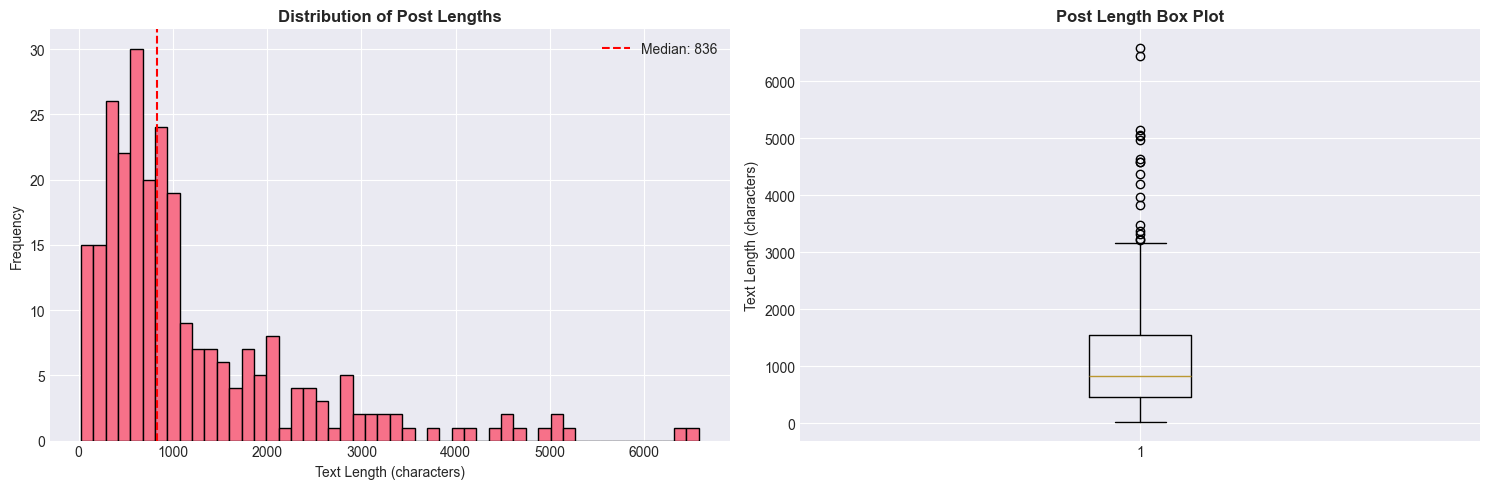


Text Length Statistics:
count     264.000000
mean     1208.776515
std      1149.523339
min        23.000000
25%       462.500000
50%       835.500000
75%      1555.500000
max      6579.000000
Name: text_length, dtype: float64


In [10]:
# Text length distribution
# LEARNING: Text length affects:
# - LLM token usage (and cost!)
# - Processing time
# - Information density

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(text_posts['text_length'], bins=50, edgecolor='black')
axes[0].set_title('Distribution of Post Lengths', fontweight='bold')
axes[0].set_xlabel('Text Length (characters)')
axes[0].set_ylabel('Frequency')
axes[0].axvline(text_posts['text_length'].median(), color='red', 
                linestyle='--', label=f'Median: {text_posts["text_length"].median():.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(text_posts['text_length'])
axes[1].set_title('Post Length Box Plot', fontweight='bold')
axes[1].set_ylabel('Text Length (characters)')

plt.tight_layout()
plt.show()

print("\nText Length Statistics:")
print(text_posts['text_length'].describe())

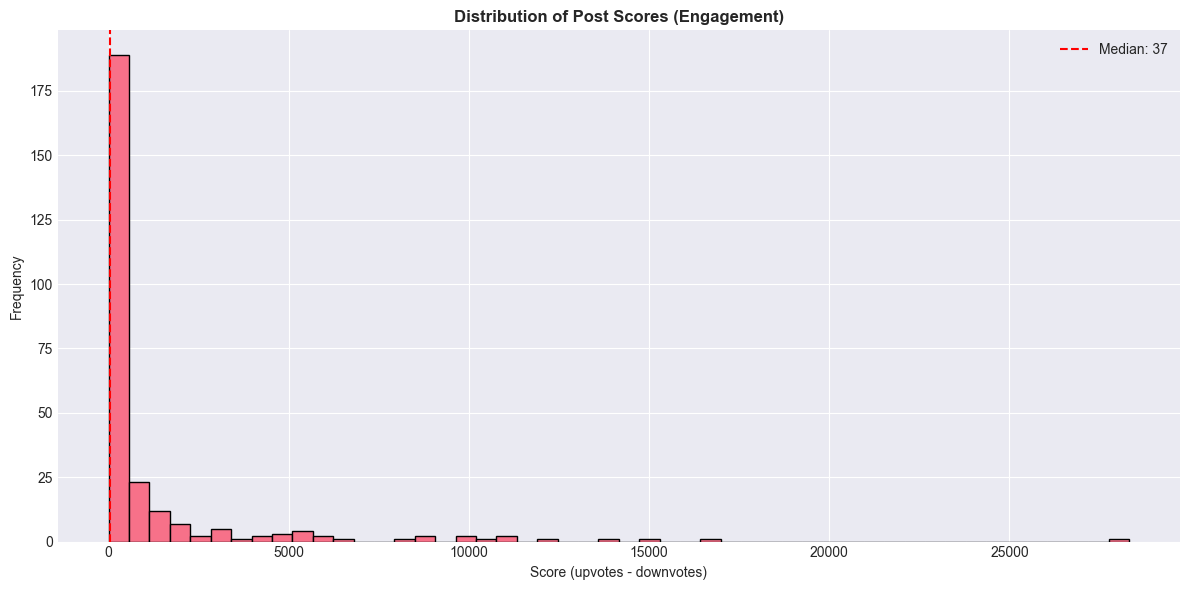


Score Statistics:
count      264.000000
mean      1181.746212
std       3098.432920
min          0.000000
25%          2.000000
50%         37.000000
75%        740.750000
max      28318.000000
Name: score, dtype: float64


In [11]:
# Post score (engagement) distribution
fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(text_posts['score'], bins=50, edgecolor='black')
ax.set_title('Distribution of Post Scores (Engagement)', fontweight='bold')
ax.set_xlabel('Score (upvotes - downvotes)')
ax.set_ylabel('Frequency')
ax.axvline(text_posts['score'].median(), color='red', 
           linestyle='--', label=f'Median: {text_posts["score"].median():.0f}')
ax.legend()
plt.tight_layout()
plt.show()

print("\nScore Statistics:")
print(text_posts['score'].describe())

## 4. Temporal Analysis

When were these posts made? Are there patterns over time?

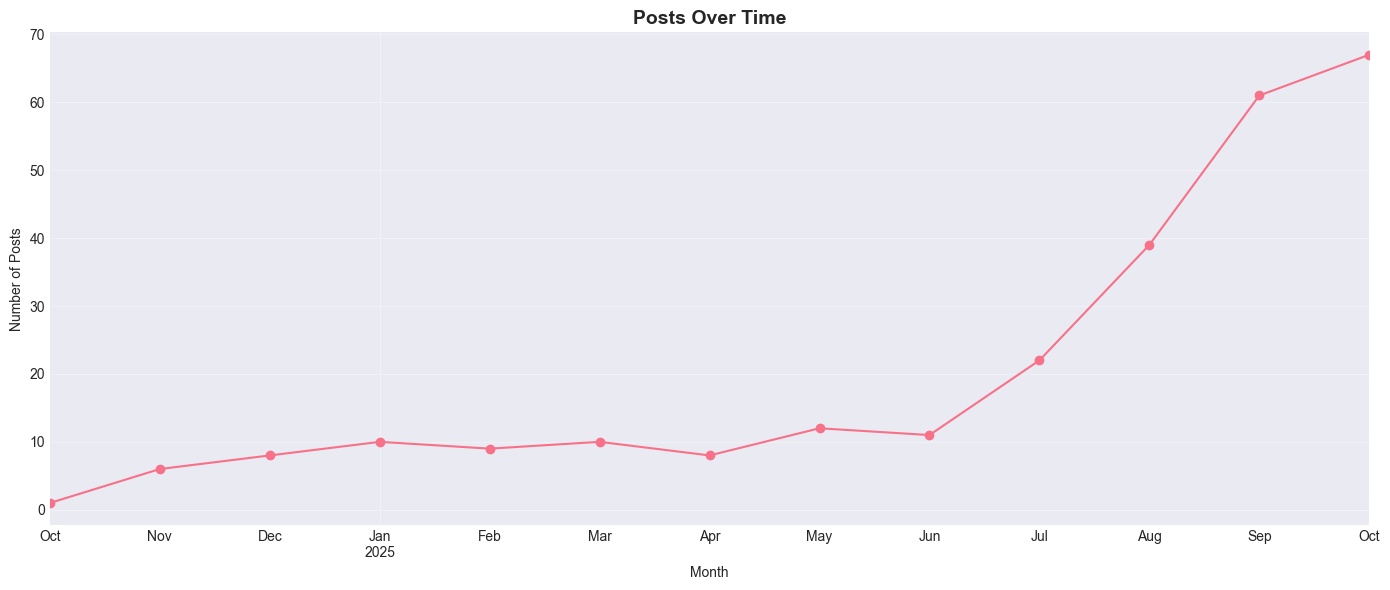

In [12]:
# Convert timestamp to datetime
text_posts['created_datetime'] = pd.to_datetime(text_posts['created_date'])
text_posts['year_month'] = text_posts['created_datetime'].dt.to_period('M')

# Posts over time
temporal_dist = text_posts.groupby('year_month').size()

fig, ax = plt.subplots(figsize=(14, 6))
temporal_dist.plot(kind='line', marker='o', ax=ax)
ax.set_title('Posts Over Time', fontsize=14, fontweight='bold')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Posts')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Text Content Analysis

Now let's analyze the actual text content - this is where NLP begins!

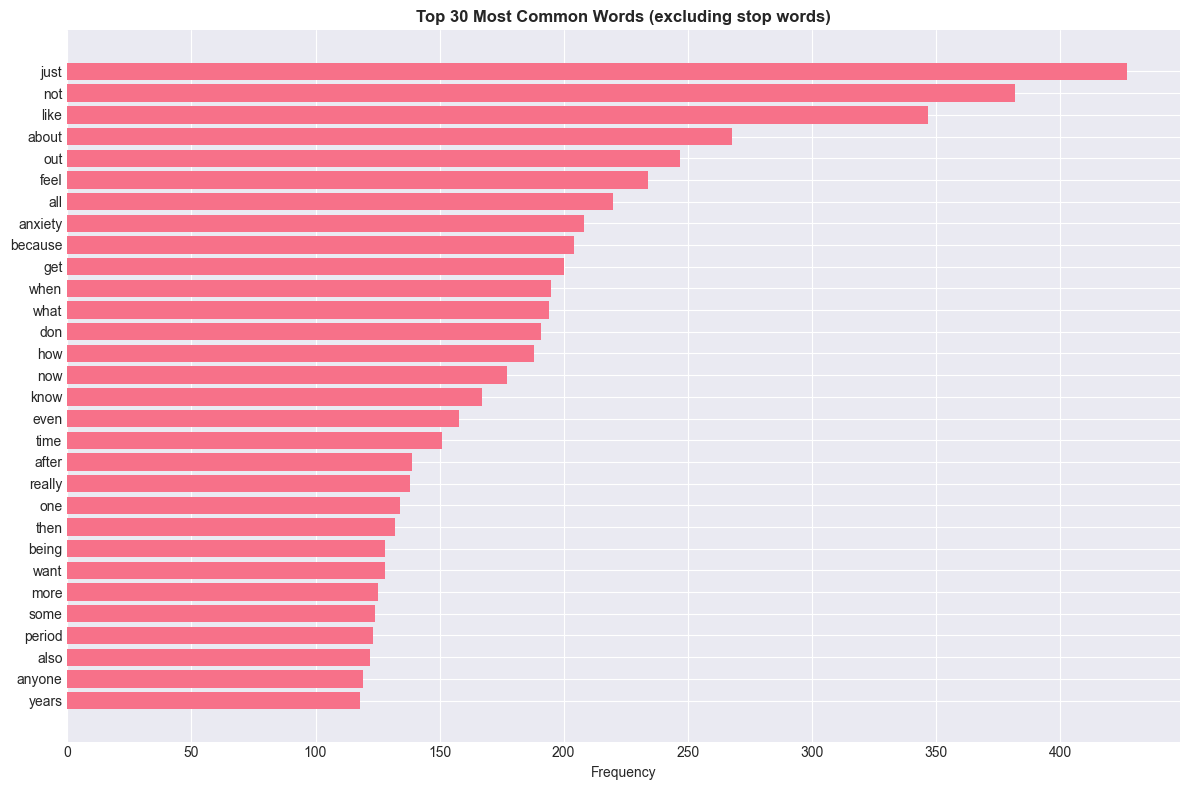

In [13]:
# Combine title and text for full content analysis
text_posts['full_text'] = text_posts['title'] + ' ' + text_posts['selftext']

# Most common words (simple tokenization)
# LEARNING: This is basic NLP - we'll use advanced methods later
def simple_tokenize(text):
    """Basic word tokenization (lowercase, split on spaces)"""
    if pd.isna(text):
        return []
    # Convert to lowercase and split
    words = re.findall(r'\b\w+\b', text.lower())
    return words

# Collect all words
all_words = []
for text in text_posts['full_text']:
    all_words.extend(simple_tokenize(text))

# Count frequencies
word_freq = Counter(all_words)

# Remove common English stop words (basic list)
stop_words = {'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 
              'of', 'with', 'by', 'from', 'as', 'is', 'was', 'are', 'been', 'be',
              'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
              'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those',
              'i', 'you', 'he', 'she', 'it', 'we', 'they', 'my', 'your', 'his', 'her',
              'its', 'our', 'their', 'me', 'him', 'us', 'them', 'im', 've', 't', 's'}

filtered_freq = {word: count for word, count in word_freq.items() 
                 if word not in stop_words and len(word) > 2}

# Top 30 most common words
top_words = Counter(filtered_freq).most_common(30)

# Visualize
words, counts = zip(*top_words)
fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(words, counts)
ax.set_title('Top 30 Most Common Words (excluding stop words)', fontweight='bold')
ax.set_xlabel('Frequency')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

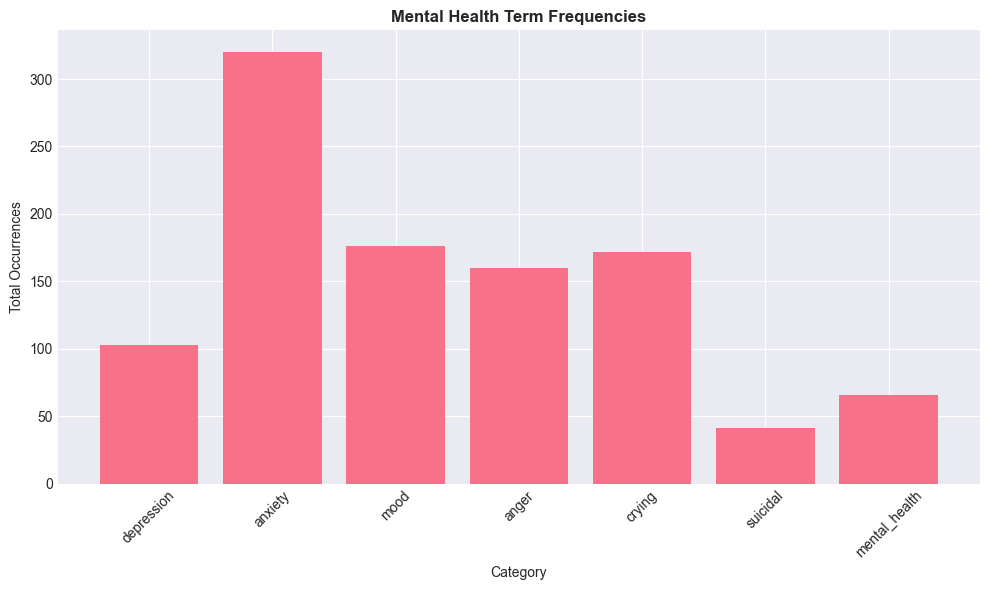


Mental Health Term Counts:
  anxiety: 320
  mood: 176
  crying: 172
  anger: 160
  depression: 103
  mental_health: 66
  suicidal: 41


In [14]:
# Mental health keyword frequency
# LEARNING: Domain-specific keyword analysis
mental_health_terms = {
    'depression': ['depression', 'depressed', 'depressing'],
    'anxiety': ['anxiety', 'anxious', 'panic'],
    'mood': ['mood', 'moods', 'emotional', 'emotions'],
    'anger': ['anger', 'angry', 'rage', 'irritable', 'irritability'],
    'crying': ['crying', 'cry', 'cried', 'tears'],
    'suicidal': ['suicidal', 'suicide', 'kill myself'],
    'mental_health': ['mental health', 'mentally']
}

def count_term_occurrences(text, terms):
    """Count how many times any variant of a term appears"""
    if pd.isna(text):
        return 0
    text_lower = text.lower()
    return sum(text_lower.count(term) for term in terms)

# Count occurrences for each category
term_counts = {}
for category, terms in mental_health_terms.items():
    term_counts[category] = text_posts['full_text'].apply(
        lambda x: count_term_occurrences(x, terms)
    ).sum()

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
categories = list(term_counts.keys())
counts = list(term_counts.values())
ax.bar(categories, counts)
ax.set_title('Mental Health Term Frequencies', fontweight='bold')
ax.set_xlabel('Category')
ax.set_ylabel('Total Occurrences')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

print("\nMental Health Term Counts:")
for category, count in sorted(term_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"  {category}: {count}")

## 6. Sample Posts Review

Let's look at actual examples to understand the data qualitatively.

In [15]:
# Show a few example posts
print("Sample Posts (high engagement):")
print("=" * 80)

# Get top posts by score
top_posts = text_posts.nlargest(3, 'score')

for idx, post in top_posts.iterrows():
    print(f"\n[{post['subreddit']}] Score: {post['score']}")
    print(f"Title: {post['title']}")
    print(f"Text: {post['selftext'][:300]}...")
    print("-" * 80)

Sample Posts (high engagement):

[TwoXChromosomes] Score: 28318
Title: Is anyone else having a panic attack right now?
Text: I’m so, so, so lost and disappointed watching the preliminary results come in. I’m confused. I’m hurt. I’m angry. I just don’t understand how many people in my country have been brainwashed to the point of voting against their own interests… How the hell did we get here? ...
--------------------------------------------------------------------------------

[TwoXChromosomes] Score: 16546
Title: Devastated about my husband’s wealthy(ish) family’s reaction to my first big gift for him. 
Text: UPDATE: I spoke with him this morning, trying to be very calm. I’m not confrontational by nature, so I put my anger aside and went into it with patience and grace. I asked if he was upset about the guitar, either the brand choice, the appearance, or something. I told him my feelings were hurt when h...
-----------------------------------------------------------------------------

## 7. Summary and Next Steps

### What We Learned:
1. **Data Quality**: Checked for missing values, duplicates
2. **Distributions**: Understood text length, engagement patterns
3. **Content**: Identified key mental health terms
4. **Temporal**: Saw when posts were created

### Next Steps for Your Learning Journey:
1. **Text Preprocessing**: Clean and normalize text
2. **Named Entity Recognition (NER)**: Extract drug names, symptoms
3. **LLM-based Extraction**: Use Claude/GPT to extract structured data
4. **Sentiment Analysis**: Analyze emotional tone
5. **Knowledge Graph**: Build relationships between entities

### Data Quality Assessment:
- Are there enough posts for analysis?
- Is the data representative?
- Do we need more data from specific subreddits?
- What preprocessing is needed?

In [16]:
# Export summary statistics
summary = {
    'total_posts': len(df),
    'text_posts': len(text_posts),
    'subreddits': text_posts['subreddit'].value_counts().to_dict(),
    'avg_text_length': text_posts['text_length'].mean(),
    'avg_score': text_posts['score'].mean(),
    'date_range': {
        'earliest': text_posts['created_datetime'].min().isoformat(),
        'latest': text_posts['created_datetime'].max().isoformat()
    },
    'mental_health_terms': term_counts
}

# Save summary
output_path = Path('../outputs/reports/eda_summary.json')
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n✓ Summary saved to: {output_path}")

TypeError: Object of type int64 is not JSON serializable